# Experiment 1: All metrics / Default parameters / TSB

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

In [2]:
project_root_path = os.path.join('..', '..')
experiment_path = os.path.join(project_root_path, 'experiments', 'allmetrics_defparams_tsb')
results_path = os.path.join(experiment_path, 'results')

save_fig_path = os.path.join(experiment_path, 'figures')
os.makedirs(save_fig_path, exist_ok=True)

In [3]:
def load_results(csv_file):
    return pd.read_csv(csv_file, index_col=0)

result_files = [file for file in os.listdir(results_path) if file.endswith('.csv')]
print(f'Number of result files: {len(result_files)}')

Number of result files: 7


In [4]:
formal_names = {
    'FF-VUS-PR': 'FF-VUS (L: 128)',
    'FF-VUS-PR-GPU': 'FF-VUS-GPU (L: 128)',
    'AUC-PR': 'AUC',
    'VUS-PR': 'VUS (L: 128)',
    'RF': 'RF',
    'AFFILIATION': 'AFFILIATION',
    'RANGE-AUC-PR': 'Range-AUC (L: 128)',
}

color_palette = {
    'FF-VUS (L: 128)': '#99cae4',          # Good
    'FF-VUS-GPU (L: 128)': '#40da70',     # Very Good
    'AUC': '#f1a73f',                # Secondary competitor
    'VUS (L: 128)': '#b02a41',            # Main competitor
    'RF': '#a6d2c3',                    # Useless competitors
    'AFFILIATION': '#95bdaf',        # Useless competitors
    'Range-AUC (L: 128)': '#84a89c',       # Useless competitors
}

In [5]:
# Initialize an empty DataFrame to store the combined data
df = pd.DataFrame()

# Read and combine all files
for file in tqdm(result_files):
    file_path = os.path.join(results_path, file)
    curr_df = pd.read_csv(file_path, index_col=0)
    df = pd.concat([df, curr_df], ignore_index=True)
    
df['Metric'] = df['Metric'].map(formal_names)
df.sample(3)

100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 73.75it/s]


,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Step,Global mask,...,Safe mask time,Thresholds time,Score mask time,Position time,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Anomalies coordinates time
12263,SMD/machine-3-11.test.csv@12.out,28695,3,66.0,NaN,AUC,0.319944,0.002104,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5898,OPPORTUNITY/S2-ADL2.test.csv@126.out,30181,2,411.0,128.0,FF-VUS-GPU (L: 128),0.044429,0.002715,1.0,True,...,0.000316,0.000091,0.000035,0.000087,0.0002,0.000166,0.000623,0.000092,0.000036,0.000352
7578,Daphnet/S03R03E4.test.csv@6.out,9599,1,268.0,NaN,AFFILIATION,0.211558,0.002814,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

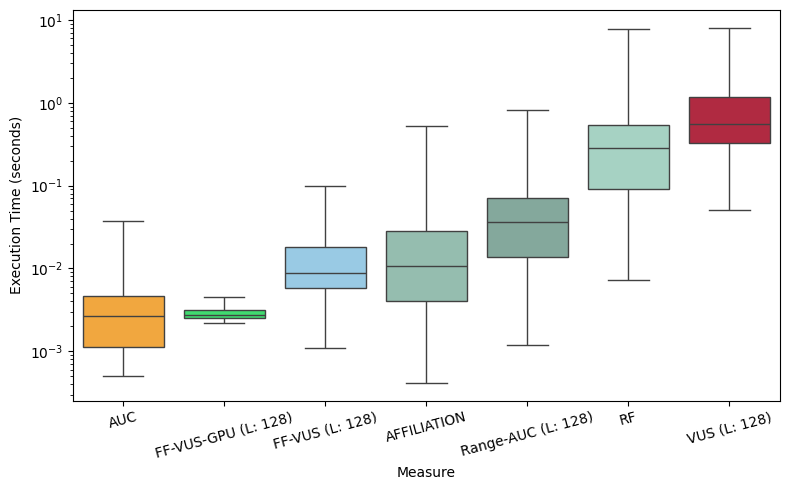

In [6]:
# What is the execution time difference
median_times = df.groupby('Metric')['Metric time'].median()
order = median_times.sort_values().index.to_list()

plt.figure(figsize=(8, 5))
sns.boxplot(
    y='Metric time', 
    x='Metric', 
    hue='Metric', 
    data=df, 
    showfliers=False, 
    log_scale=True, 
    palette=color_palette, 
    order=order, 
    saturation=1,
)
plt.xlabel('Measure')
plt.ylabel('Execution Time (seconds)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_comparison.svg'))
plt.show()

In [7]:
# # What is the error between the difference metrics
# plt.figure(figsize=(8, 5))
# metrics = df['Metric'].unique()

# values_df = df[['Time series', 'Metric', 'Metric value']]
# values_df = values_df.pivot(columns='Metric', index='Time series', values='Metric value')
# dif_df = values_df.copy()
# for metric in metrics: 
#     dif_df[metric] = values_df[metric] - values_df['AUC']
# dif_df

# sns.boxplot(dif_df.abs(), showfliers=True, palette=color_palette, order=order, saturation=1)
# plt.xlabel('Measure')
# plt.ylabel('Error to AUC-PR')
# plt.tight_layout()
# plt.savefig(os.path.join(save_fig_path, 'error_to_aucpr.svg'))
# plt.show()

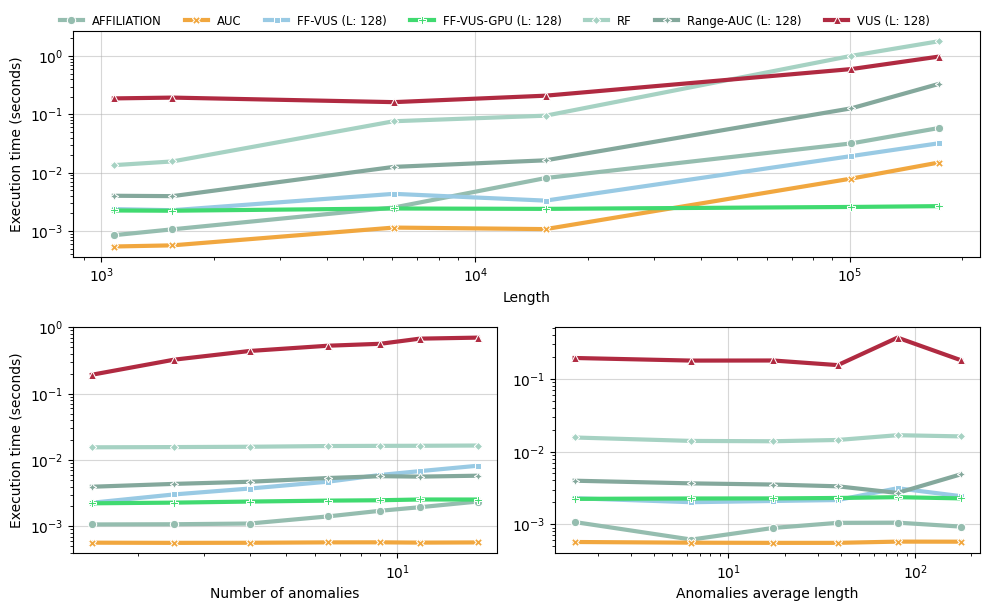

In [10]:
bins = 20
attr_control = {}
attributes = ["Length", "Number of anomalies", "Anomalies average length"]
for attr in attributes:
    df[f'{attr} bin'] = pd.qcut(df[attr], q=bins, duplicates='drop')
    attr_control[attr] = df[f'{attr} bin'].value_counts().idxmax()

attr_axis = {
    "Length": (2, 1, 1), 
    "Number of anomalies": (2, 2, 3), 
    "Anomalies average length": (2, 2, 4)
}
fig = plt.figure(figsize=(10, 6))
for i, attribute in enumerate(attributes):
    axis = fig.add_subplot(*attr_axis[attribute])

    mask = pd.Series(True, index=df.index)
    for attr in attributes:
        if attr != attribute:
            mask &= (df[f'{attr} bin'] == attr_control[attr])
    curr_df = df[mask]
    
    # Group by bin and metric, compute mean
    grouped = (
        curr_df
        .groupby([f'{attribute} bin', 'Metric'], observed=False)['Metric time']
        .mean()
        .reset_index()
    )
  
    # Convert bin to the midpoint for plotting
    grouped['bin_center'] = grouped[f'{attribute} bin'].apply(lambda x: x.mid)

    # Plot
    sns.lineplot(
        x='bin_center',
        y='Metric time',
        hue='Metric',
        data=grouped,
        ax=axis,
        palette=color_palette,
        markers=True,
        style='Metric',
        dashes = False,
        linewidth=3,
        # size='Metric', 
        # size_order=['FF-VUS-GPU (L: 128)', 'FF-VUS (L: 128)', 'AFFILIATION', 'VUS (L: 128)', 'Range-AUC (L: 128)', 'RF', 'AUC']
    )

    axis.set_xlabel(attribute)
    axis.set_ylabel("Execution time (seconds)" if i != 2 else "")
    axis.set_yscale('log')
    axis.set_xscale('log')
    axis.grid(axis='both', alpha=0.5)
    if i != 0: 
        axis.get_legend().remove()
    else:
        legend_axis = axis

handles, labels = legend_axis.get_legend_handles_labels()
legend_axis.get_legend().remove()
fig.legend(
    handles,
    labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=len(labels),
    frameon=False,
    fontsize='small'
)

plt.tight_layout()
plt.savefig(os.path.join(save_fig_path, 'exec_time_per_attr.svg'))
plt.show()

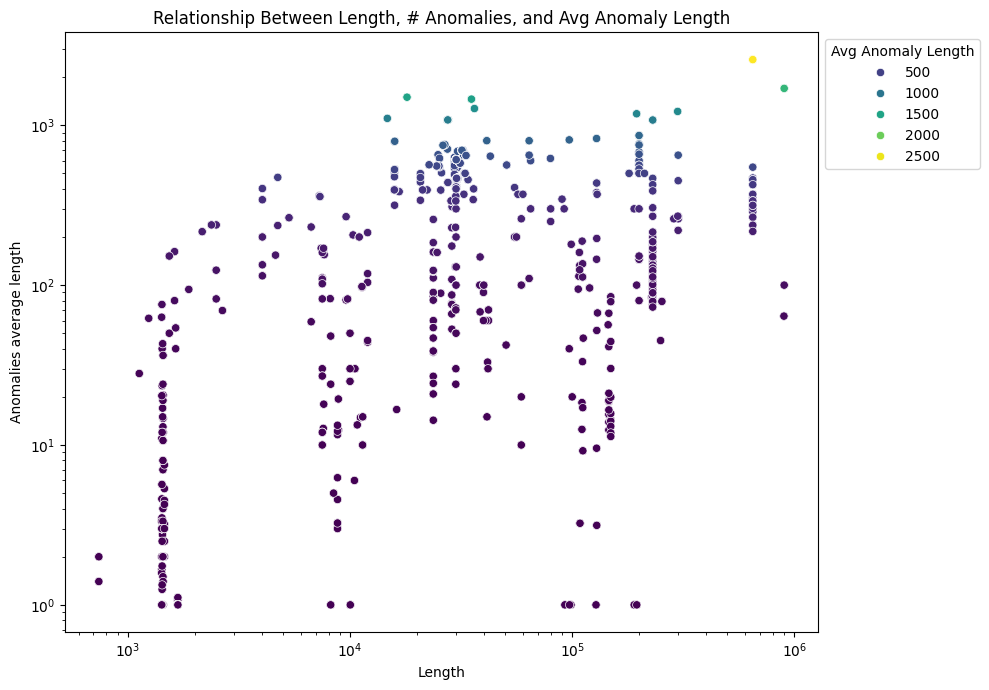

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.scatterplot(
    data=df,
    x='Length',
    y='Anomalies average length',
    # size='Anomalies average length',
    hue='Anomalies average length',
    palette='viridis',
    sizes=(20, 300),
    ax=ax
)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Relationship Between Length, # Anomalies, and Avg Anomaly Length")
ax.legend(title='Avg Anomaly Length', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

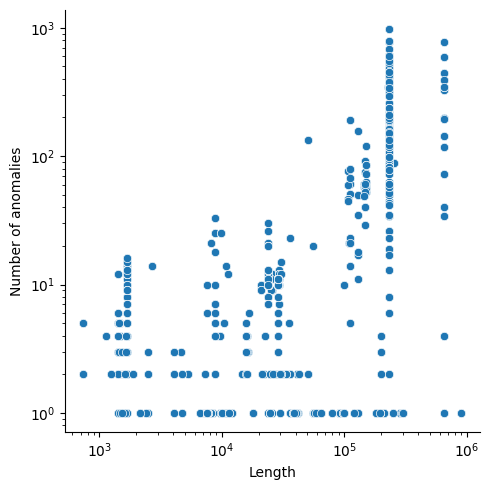

In [18]:
g = sns.relplot(
    data=df,
    x='Length',
    y='Number of anomalies',
    # col='Anomalies average length',
    kind='scatter',
    # col_wrap=3,
    # height=4,
    # aspect=1.2,
)

g.set(xscale="log", yscale="log")
plt.tight_layout()
plt.show()

In [23]:
df['Dataset'] = df.apply(lambda row: row['Time series'].split('/')[0] , axis=1)
df

,Time series,Length,Number of anomalies,Anomalies average length,Slope size,Metric,Metric value,Metric time,Step,Global mask,...,Slopes time,Existence time,Confusion matrix time,Precision recall curve time,Integral time,Anomalies coordinates time,Length bin,Number of anomalies bin,Anomalies average length bin,Dataset
0,Daphnet/S03R03E4.test.csv@3.out,9599,1,268.000000,128.0,Range-AUC (L: 128),0.029295,0.032347,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(2498.0, 9599.0]","(0.999, 2.0]","(200.0, 300.0]",Daphnet
1,Daphnet/S09R01E4.test.csv@3.out,9599,1,268.000000,128.0,Range-AUC (L: 128),0.025808,0.028348,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(2498.0, 9599.0]","(0.999, 2.0]","(200.0, 300.0]",Daphnet
2,Daphnet/S03R02E0.test.csv@4.out,16639,6,384.333333,128.0,Range-AUC (L: 128),0.573444,0.042141,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(9599.0, 21215.0]","(5.0, 8.0]","(300.0, 394.0]",Daphnet
3,Daphnet/S09R01E4.test.csv@6.out,9599,1,268.000000,128.0,Range-AUC (L: 128),0.026826,0.028375,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(2498.0, 9599.0]","(0.999, 2.0]","(200.0, 300.0]",Daphnet
4,Daphnet/S03R02E0.test.csv@3.out,16639,6,384.333333,128.0,Range-AUC (L: 128),0.112658,0.048144,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(9599.0, 21215.0]","(5.0, 8.0]","(300.0, 394.0]",Daphnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13183,KDD21/026_UCR_Anomaly_DISTORTEDInternalBleedin...,7600,1,170.000000,NaN,AUC,0.130575,0.000922,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(2498.0, 9599.0]","(0.999, 2.0]","(150.491, 200.0]",KDD21
13184,KDD21/170_UCR_Anomaly_gaitHunt1_18500_33070_33...,63999,1,110.000000,NaN,AUC,0.002341,0.004856,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(56122.0, 146254.0]","(0.999, 2.0]","(108.545, 144.0]",KDD21
13185,KDD21/223_UCR_Anomaly_mit14046longtermecg_7412...,180385,1,500.000000,NaN,AUC,0.020801,0.013901,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(146254.0, 200000.0]","(0.999, 2.0]","(456.5, 500.0]",KDD21
13186,KDD21/213_UCR_Anomaly_STAFFIIIDatabase_33211_1...,299999,1,450.000000,NaN,AUC,0.013448,0.023224,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"(230399.0, 899999.0]","(0.999, 2.0]","(394.0, 456.5]",KDD21


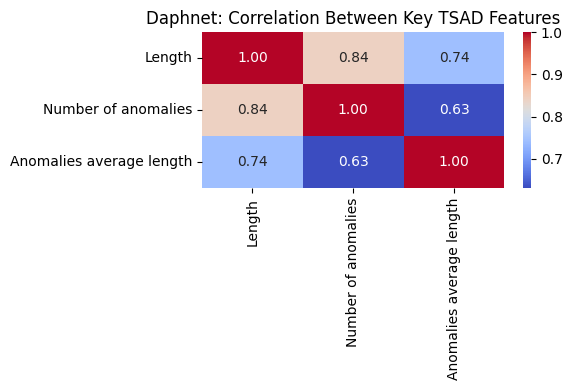

/home/sylli/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/sylli/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


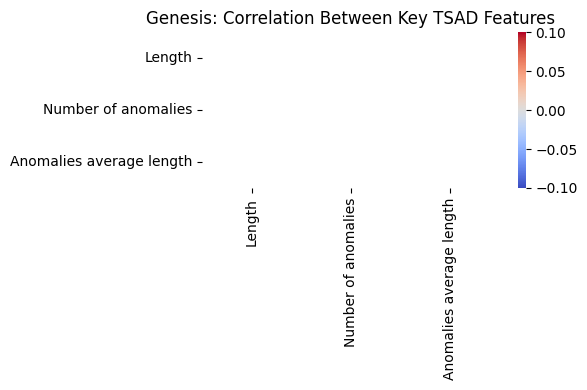

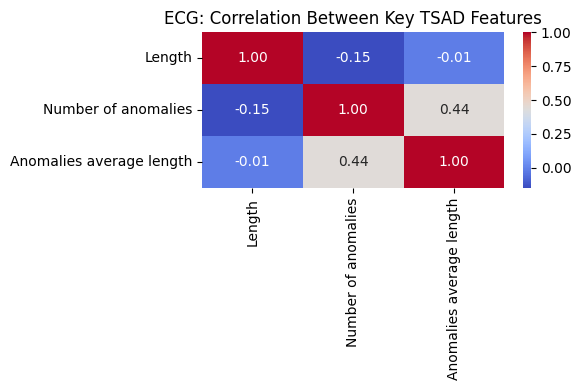

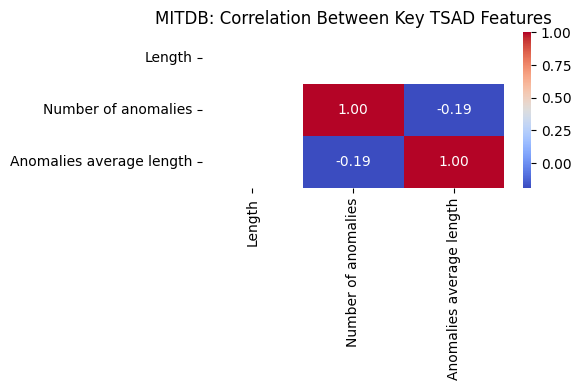

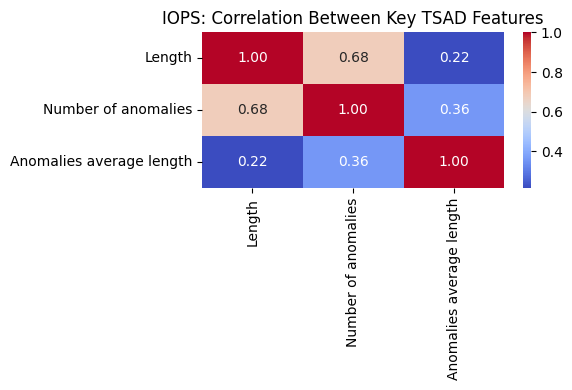

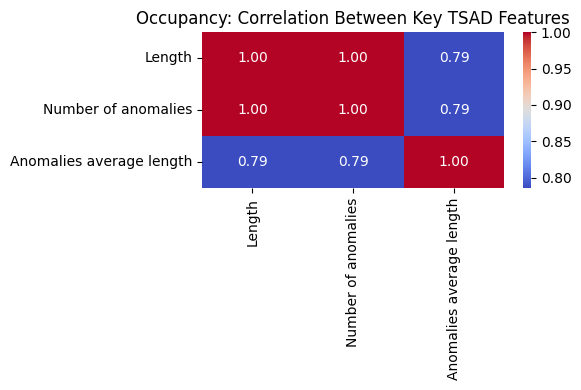

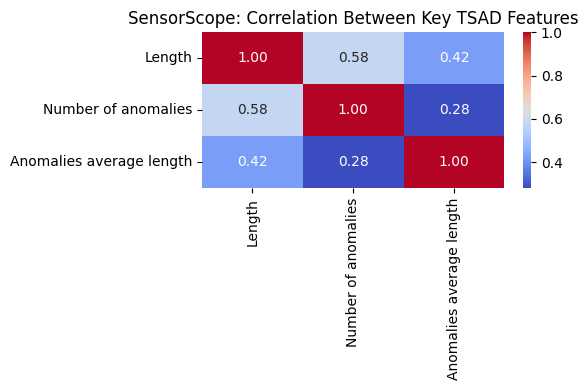

/home/sylli/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/sylli/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


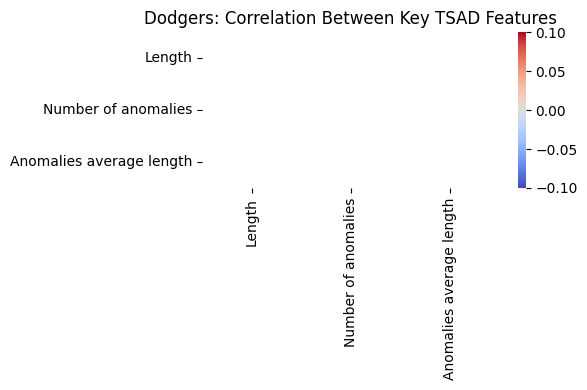

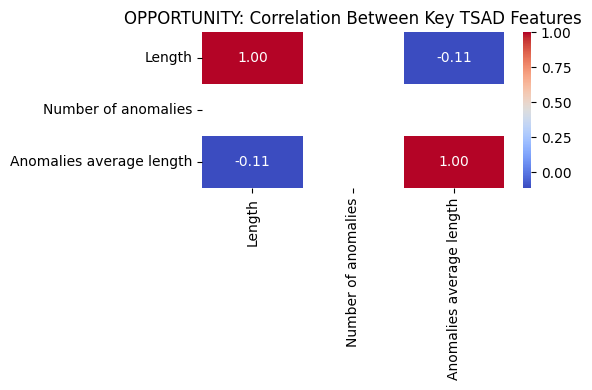

/home/sylli/.local/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/sylli/.local/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


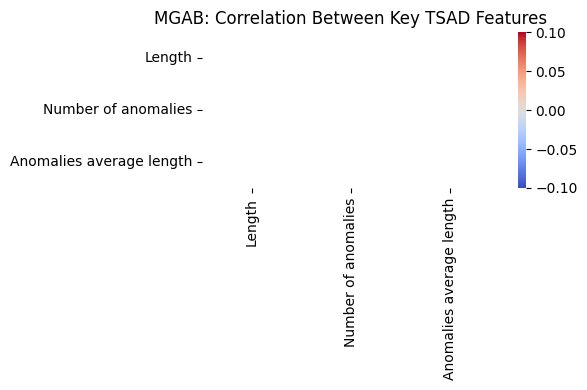

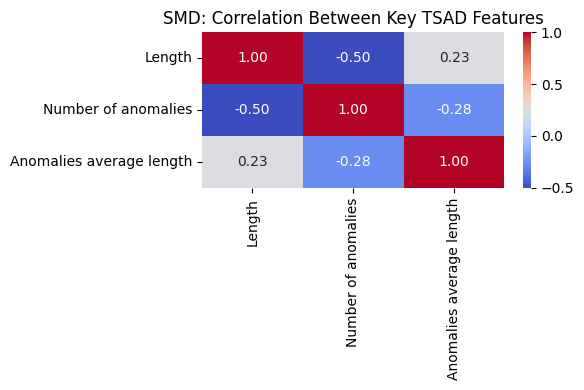

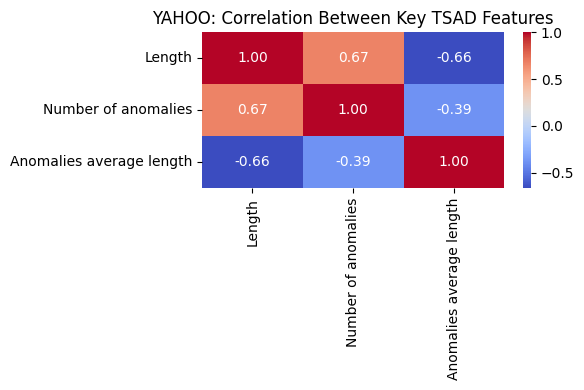

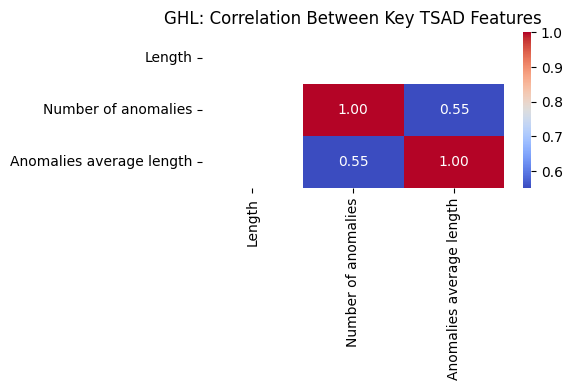

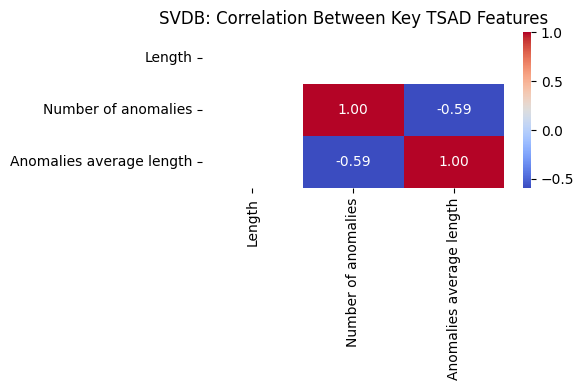

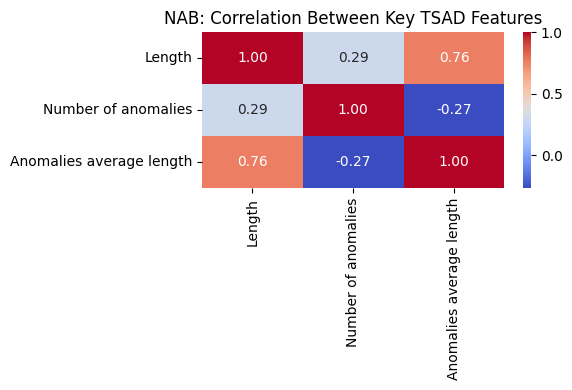

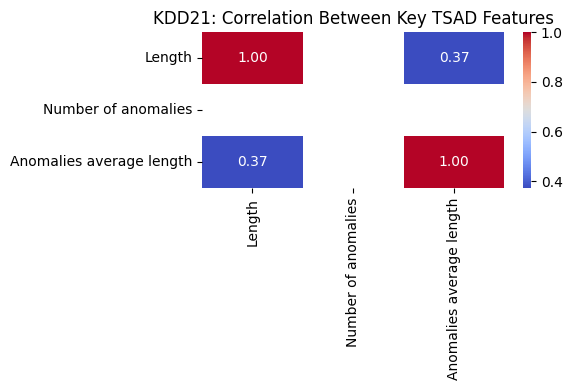

In [25]:
for dataset in df['Dataset'].unique():
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        df[df['Dataset'] == dataset][['Length', 'Number of anomalies', 'Anomalies average length']].corr(method='spearman'),
        annot=True,
        cmap='coolwarm',
        fmt='.2f'
    )
    plt.title(f"{dataset}: Correlation Between Key TSAD Features")
    plt.tight_layout()
    plt.show()

In [31]:
[10**x for x in range(5)]

[1, 10, 100, 1000, 10000]

In [33]:
[2**x for x in range(14)]

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

In [39]:
for i in range(100):
    if 2**i > 10**9:
        print(f"{i} -> {2**i}")
        break

30 -> 1073741824


In [41]:
[f"{i} -> {2**i}" for i in range(32)]

['0 -> 1',
 '1 -> 2',
 '2 -> 4',
 '3 -> 8',
 '4 -> 16',
 '5 -> 32',
 '6 -> 64',
 '7 -> 128',
 '8 -> 256',
 '9 -> 512',
 '10 -> 1024',
 '11 -> 2048',
 '12 -> 4096',
 '13 -> 8192',
 '14 -> 16384',
 '15 -> 32768',
 '16 -> 65536',
 '17 -> 131072',
 '18 -> 262144',
 '19 -> 524288',
 '20 -> 1048576',
 '21 -> 2097152',
 '22 -> 4194304',
 '23 -> 8388608',
 '24 -> 16777216',
 '25 -> 33554432',
 '26 -> 67108864',
 '27 -> 134217728',
 '28 -> 268435456',
 '29 -> 536870912',
 '30 -> 1073741824',
 '31 -> 2147483648']